In [9]:
import jax
from random_events.set import SetElement

include_variables = 20

class Digit(SetElement):
    EMPTY_SET = -1
    ZERO = 0
    ONE = 1
    TWO = 2
    THREE = 3
    FOUR = 4
    FIVE = 5
    SIX = 6
    SEVEN = 7
    EIGHT = 8
    NINE = 9

In [10]:
from sortedcontainers import SortedSet
from random_events.variable import Symbolic, Continuous

variables = SortedSet([Symbolic("Digit", Digit)] + [Continuous(f"Pixel_{i}_{j}") for i in range(8) for j in range(8)])
variables = variables[:include_variables]

In [11]:
from sklearn import datasets
import numpy as np
from sklearn.preprocessing import MinMaxScaler
digits = datasets.load_digits(as_frame=False)
x = digits.data
y = digits.target
data = np.concatenate((y.reshape(-1, 1), x), axis=1)[:, :include_variables]
data[:, 1:] = MinMaxScaler((-1, 1)).fit_transform(data[:, 1:])

In [12]:
from probabilistic_model.learning.region_graph.region_graph import RegionGraph

region_graph = RegionGraph(variables, repetitions=6, depth=3, partitions=2)
region_graph = region_graph.create_random_region_graph()
model = region_graph.as_probabilistic_circuit(input_units=16, sum_units=5)

/home/tom/probabilistic_model/src/probabilistic_model/learning/region_graph/region_graph.py:132: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  node.layer = GaussianLayer(variable_index, location=location, log_scale=log_scale, min_scale=jnp.full_like(location, 0.01))
/home/tom/probabilistic_model/src/probabilistic_model/learning/region_graph/region_graph.py:139: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  node.layer = DiscreteLayer(variable_index, log_probabilities=log_probabilities)
/home/tom/probabilistic_model/src/probabilistic_model/learning/region_graph/region_graph.py:163: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  node.layer = ProductLayer([child.layer for child in children], sparse_edges)


Converting to nx: 100%|██████████| 9030/9030 [00:01<00:00, 7938.53it/s, Creating Gaussian distributions for variable Pixel_2_2]                                                                                                                                                                                                                                                                                                                                                                                                                                                   


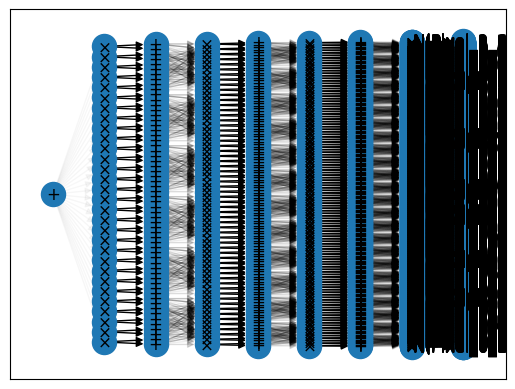

ProbabilisticCircuit with 3319 nodes and 7110 edges


In [17]:
from matplotlib import pyplot as plt

nx_model = model.to_nx()
nx_model.plot_structure()
plt.show()

In [14]:
print(model.root.number_of_trainable_parameters)

8514


In [15]:
import optax
import equinox as eqx
import jax.numpy as jnp
import tqdm

root = model.root

@eqx.filter_jit
def loss(p, x):
    ll = p.log_likelihood_of_nodes(x)
    return -jnp.mean(ll)

optimizer = optax.adamw(0.01)
opt_state = optimizer.init(eqx.filter(root, eqx.is_inexact_array))



In [16]:
for _ in tqdm.trange(1000):
    loss_value, grads = eqx.filter_value_and_grad(loss)(root, data)

    updates, opt_state = optimizer.update(
        grads, opt_state, eqx.filter(root, eqx.is_inexact_array)
    )
    root = eqx.apply_updates(root, updates)
    print(loss_value)

  0%|          | 1/1000 [00:25<6:58:26, 25.13s/it]

29.737188


  0%|          | 2/1000 [00:25<2:54:32, 10.49s/it]

29.47432


  0%|          | 3/1000 [00:25<1:36:32,  5.81s/it]

29.211369


  0%|          | 4/1000 [00:25<59:56,  3.61s/it]  

28.948439


  0%|          | 5/1000 [00:26<39:40,  2.39s/it]

28.68565


  1%|          | 6/1000 [00:26<27:30,  1.66s/it]

28.423126


  1%|          | 7/1000 [00:26<19:47,  1.20s/it]

28.160986


  1%|          | 8/1000 [00:26<14:40,  1.13it/s]

27.899359


  1%|          | 9/1000 [00:27<15:15,  1.08it/s]

27.63834


  1%|          | 10/1000 [00:28<11:42,  1.41it/s]

27.378036


  1%|          | 11/1000 [00:28<09:18,  1.77it/s]

27.118507


  1%|          | 12/1000 [00:28<07:39,  2.15it/s]

26.859802


  1%|▏         | 13/1000 [00:28<06:29,  2.54it/s]

26.601925


  1%|▏         | 14/1000 [00:28<05:38,  2.91it/s]

26.344856


  2%|▏         | 15/1000 [00:29<05:05,  3.22it/s]

26.08853


  2%|▏         | 16/1000 [00:29<04:40,  3.50it/s]

25.832838


  2%|▏         | 17/1000 [00:29<04:25,  3.71it/s]

25.577635


  2%|▏         | 18/1000 [00:29<04:14,  3.85it/s]

25.322714


  2%|▏         | 19/1000 [00:30<04:06,  3.99it/s]

25.067831


  2%|▏         | 20/1000 [00:30<04:02,  4.04it/s]

24.812706


  2%|▏         | 21/1000 [00:30<03:58,  4.11it/s]

24.55703


  2%|▏         | 22/1000 [00:30<03:57,  4.11it/s]

24.3005


  2%|▏         | 23/1000 [00:31<03:53,  4.19it/s]

24.042837


  2%|▏         | 24/1000 [00:31<03:50,  4.23it/s]

23.783783


  2%|▎         | 25/1000 [00:31<03:51,  4.20it/s]

23.523144


  3%|▎         | 26/1000 [00:31<03:52,  4.20it/s]

23.260769


  3%|▎         | 27/1000 [00:32<03:58,  4.09it/s]

22.996605


  3%|▎         | 28/1000 [00:32<04:05,  3.96it/s]

22.730652


  3%|▎         | 29/1000 [00:33<07:51,  2.06it/s]

22.462992


  3%|▎         | 30/1000 [00:33<06:43,  2.40it/s]

22.19377


  3%|▎         | 31/1000 [00:33<05:52,  2.75it/s]

21.92319


  3%|▎         | 32/1000 [00:34<05:16,  3.06it/s]

21.65147


  3%|▎         | 33/1000 [00:34<04:50,  3.33it/s]

21.378859


  3%|▎         | 34/1000 [00:34<04:32,  3.55it/s]

21.105589


  4%|▎         | 35/1000 [00:34<04:19,  3.72it/s]

20.831856


  4%|▎         | 36/1000 [00:35<04:10,  3.85it/s]

20.557821


  4%|▎         | 37/1000 [00:35<04:03,  3.96it/s]

20.28359


  4%|▍         | 38/1000 [00:35<03:59,  4.02it/s]

20.009222


  4%|▍         | 39/1000 [00:35<03:56,  4.06it/s]

19.734745


  4%|▍         | 40/1000 [00:35<03:54,  4.10it/s]

19.460169


  4%|▍         | 41/1000 [00:36<03:50,  4.16it/s]

19.185492


  4%|▍         | 42/1000 [00:36<03:50,  4.16it/s]

18.910725


  4%|▍         | 43/1000 [00:36<03:49,  4.17it/s]

18.635893


  4%|▍         | 44/1000 [00:36<03:49,  4.17it/s]

18.36104


  4%|▍         | 45/1000 [00:37<03:48,  4.18it/s]

18.086218


  5%|▍         | 46/1000 [00:37<03:48,  4.18it/s]

17.811481


  5%|▍         | 47/1000 [00:37<03:48,  4.17it/s]

17.536873


  5%|▍         | 48/1000 [00:37<03:47,  4.18it/s]

17.262432


  5%|▍         | 49/1000 [00:38<07:32,  2.10it/s]

16.98819


  5%|▌         | 50/1000 [00:39<06:27,  2.45it/s]

16.714167


  5%|▌         | 51/1000 [00:39<05:52,  2.69it/s]

16.440378


  5%|▌         | 52/1000 [00:39<05:34,  2.83it/s]

16.16683


  5%|▌         | 53/1000 [00:40<05:02,  3.13it/s]

15.89353


  5%|▌         | 54/1000 [00:40<04:38,  3.39it/s]

15.620475


  6%|▌         | 55/1000 [00:40<04:56,  3.18it/s]

15.347657


  6%|▌         | 56/1000 [00:40<05:10,  3.04it/s]

15.075076


  6%|▌         | 57/1000 [00:41<05:10,  3.04it/s]

14.802739


  6%|▌         | 58/1000 [00:41<05:21,  2.93it/s]

14.530663


  6%|▌         | 59/1000 [00:41<05:20,  2.93it/s]

14.2588825


  6%|▌         | 60/1000 [00:42<05:14,  2.99it/s]

13.987446


  6%|▌         | 61/1000 [00:42<04:44,  3.30it/s]

13.716394


  6%|▌         | 62/1000 [00:42<04:56,  3.17it/s]

13.445757


  6%|▋         | 63/1000 [00:43<04:33,  3.43it/s]

13.175535


  6%|▋         | 64/1000 [00:43<04:18,  3.62it/s]

12.9057045


  6%|▋         | 65/1000 [00:43<04:07,  3.77it/s]

12.636225


  7%|▋         | 66/1000 [00:43<04:00,  3.88it/s]

12.367073


  7%|▋         | 67/1000 [00:44<07:52,  1.98it/s]

12.098268


  7%|▋         | 68/1000 [00:45<06:45,  2.30it/s]

11.829874


  7%|▋         | 69/1000 [00:45<05:50,  2.66it/s]

11.561957


  7%|▋         | 70/1000 [00:45<05:09,  3.00it/s]

11.294528


  7%|▋         | 71/1000 [00:45<04:41,  3.30it/s]

11.02749


  7%|▋         | 72/1000 [00:46<04:20,  3.56it/s]

10.760657


  7%|▋         | 73/1000 [00:46<04:06,  3.76it/s]

10.493794


  7%|▋         | 74/1000 [00:46<03:59,  3.87it/s]

10.226674


  8%|▊         | 75/1000 [00:46<03:54,  3.95it/s]

9.959078


  8%|▊         | 76/1000 [00:47<03:49,  4.02it/s]

9.690765


  8%|▊         | 77/1000 [00:47<03:43,  4.12it/s]

9.42145


  8%|▊         | 78/1000 [00:47<03:42,  4.15it/s]

9.150743


  8%|▊         | 79/1000 [00:47<03:54,  3.92it/s]

8.878184


  8%|▊         | 80/1000 [00:48<03:50,  3.99it/s]

8.603383


  8%|▊         | 81/1000 [00:48<03:46,  4.06it/s]

8.326106


  8%|▊         | 82/1000 [00:48<03:44,  4.08it/s]

8.046225


  8%|▊         | 83/1000 [00:48<03:42,  4.12it/s]

7.7637515


  8%|▊         | 84/1000 [00:49<03:56,  3.87it/s]

7.4789257


  8%|▊         | 85/1000 [00:49<03:49,  3.99it/s]

7.1921477


  9%|▊         | 86/1000 [00:49<03:46,  4.04it/s]

6.9038634


  9%|▊         | 87/1000 [00:50<07:10,  2.12it/s]

6.614384


  9%|▉         | 88/1000 [00:50<06:06,  2.49it/s]

6.323777


  9%|▉         | 89/1000 [00:51<05:22,  2.82it/s]

6.032107


  9%|▉         | 90/1000 [00:51<04:53,  3.11it/s]

5.7395315


  9%|▉         | 91/1000 [00:51<04:30,  3.36it/s]

5.44618


  9%|▉         | 92/1000 [00:51<04:13,  3.58it/s]

5.1518984


  9%|▉         | 93/1000 [00:52<04:15,  3.55it/s]

4.856099


  9%|▉         | 94/1000 [00:52<04:11,  3.60it/s]

4.5583205


 10%|▉         | 95/1000 [00:52<04:05,  3.68it/s]

4.2585278


 10%|▉         | 96/1000 [00:52<03:54,  3.85it/s]

3.957126


 10%|▉         | 97/1000 [00:53<03:49,  3.93it/s]

3.6548443


 10%|▉         | 98/1000 [00:53<03:47,  3.96it/s]

3.3522713


 10%|▉         | 99/1000 [00:53<03:43,  4.03it/s]

3.0495906


 10%|█         | 100/1000 [00:53<04:00,  3.74it/s]

2.7468197


 10%|█         | 101/1000 [00:54<03:53,  3.85it/s]

2.4449558


 10%|█         | 102/1000 [00:54<03:47,  3.95it/s]

2.1448224


 10%|█         | 103/1000 [00:54<03:43,  4.01it/s]

1.8463657


 10%|█         | 104/1000 [00:55<07:06,  2.10it/s]

1.5489362


 10%|█         | 105/1000 [00:55<06:02,  2.47it/s]

1.2517598


 11%|█         | 106/1000 [00:56<05:18,  2.81it/s]

0.95438147


 11%|█         | 107/1000 [00:56<04:45,  3.13it/s]

0.6567047


 11%|█         | 108/1000 [00:56<04:25,  3.36it/s]

0.35910928


 11%|█         | 109/1000 [00:56<04:20,  3.42it/s]

0.0621097


 11%|█         | 110/1000 [00:57<04:05,  3.62it/s]

-0.23353441


 11%|█         | 111/1000 [00:57<04:05,  3.62it/s]

-0.5272939


 11%|█         | 112/1000 [00:57<03:56,  3.76it/s]

-0.8180187


 11%|█▏        | 113/1000 [00:57<03:49,  3.86it/s]

-1.104285


 11%|█▏        | 114/1000 [00:58<03:48,  3.88it/s]

-1.3859525


 12%|█▏        | 115/1000 [00:58<03:45,  3.93it/s]

-1.6632879


 12%|█▏        | 116/1000 [00:58<03:40,  4.02it/s]

-1.9381491


 12%|█▏        | 117/1000 [00:58<03:36,  4.08it/s]

-2.2144048


 12%|█▏        | 118/1000 [00:59<03:46,  3.89it/s]

-2.4937463


 12%|█▏        | 119/1000 [00:59<03:42,  3.96it/s]

-2.7774627


 12%|█▏        | 120/1000 [00:59<03:38,  4.03it/s]

-3.0643594


 12%|█▏        | 121/1000 [00:59<03:35,  4.08it/s]

-3.3524728


 12%|█▏        | 122/1000 [01:00<03:34,  4.09it/s]

-3.6369052


 12%|█▏        | 123/1000 [01:00<03:40,  3.98it/s]

-3.9145412


 12%|█▏        | 124/1000 [01:01<06:56,  2.10it/s]

-4.186443


 12%|█▎        | 125/1000 [01:01<05:54,  2.47it/s]

-4.455991


 13%|█▎        | 126/1000 [01:01<05:17,  2.76it/s]

-4.726597


 13%|█▎        | 127/1000 [01:02<04:44,  3.06it/s]

-5.000609


 13%|█▎        | 128/1000 [01:02<04:25,  3.29it/s]

-5.278629


 13%|█▎        | 129/1000 [01:02<04:12,  3.45it/s]

-5.5572653


 13%|█▎        | 130/1000 [01:02<04:07,  3.51it/s]

-5.8329005


 13%|█▎        | 131/1000 [01:03<03:59,  3.63it/s]

-6.1028357


 13%|█▎        | 132/1000 [01:03<03:56,  3.66it/s]

-6.366867


 13%|█▎        | 133/1000 [01:03<03:47,  3.80it/s]

-6.6262264


 13%|█▎        | 134/1000 [01:03<03:45,  3.84it/s]

-6.8817163


 14%|█▎        | 135/1000 [01:04<03:42,  3.88it/s]

-7.1336794


 14%|█▎        | 136/1000 [01:04<03:49,  3.77it/s]

-7.382053


 14%|█▎        | 137/1000 [01:04<03:40,  3.91it/s]

-7.626834


 14%|█▍        | 138/1000 [01:04<03:37,  3.97it/s]

-7.8682475


 14%|█▍        | 139/1000 [01:05<03:35,  4.00it/s]

-8.107052


 14%|█▍        | 140/1000 [01:05<03:32,  4.06it/s]

-8.344061


 14%|█▍        | 141/1000 [01:05<03:29,  4.09it/s]

-8.579617


 14%|█▍        | 142/1000 [01:05<03:37,  3.94it/s]

-8.813693


 14%|█▍        | 143/1000 [01:06<03:33,  4.02it/s]

-9.04534


 14%|█▍        | 144/1000 [01:07<06:49,  2.09it/s]

-9.274643


 14%|█▍        | 145/1000 [01:07<05:46,  2.47it/s]

-9.503472


 15%|█▍        | 146/1000 [01:07<05:02,  2.83it/s]

-9.733519


 15%|█▍        | 147/1000 [01:07<04:52,  2.92it/s]

-9.966006


 15%|█▍        | 148/1000 [01:08<04:25,  3.21it/s]

-10.196393


 15%|█▍        | 149/1000 [01:08<04:15,  3.33it/s]

-10.415304


 15%|█▌        | 150/1000 [01:08<03:59,  3.55it/s]

-10.619338


 15%|█▌        | 151/1000 [01:08<03:52,  3.65it/s]

-10.814566


 15%|█▌        | 152/1000 [01:09<03:49,  3.69it/s]

-11.010515


 15%|█▌        | 153/1000 [01:09<03:42,  3.81it/s]

-11.212171


 15%|█▌        | 154/1000 [01:09<03:44,  3.77it/s]

-11.418363


 16%|█▌        | 155/1000 [01:09<03:44,  3.77it/s]

-11.624466


 16%|█▌        | 156/1000 [01:10<03:36,  3.90it/s]

-11.825469


 16%|█▌        | 157/1000 [01:10<03:35,  3.92it/s]

-12.018147


 16%|█▌        | 158/1000 [01:10<03:28,  4.05it/s]

-12.204539


 16%|█▌        | 159/1000 [01:10<03:25,  4.10it/s]

-12.388762


 16%|█▌        | 160/1000 [01:11<03:23,  4.14it/s]

-12.572868


 16%|█▌        | 161/1000 [01:11<03:21,  4.17it/s]

-12.757861


 16%|█▌        | 162/1000 [01:12<06:34,  2.13it/s]

-12.942198


 16%|█▋        | 163/1000 [01:12<05:35,  2.50it/s]

-13.123124


 16%|█▋        | 164/1000 [01:12<04:55,  2.83it/s]

-13.300629


 16%|█▋        | 165/1000 [01:13<04:28,  3.11it/s]

-13.475806


 17%|█▋        | 166/1000 [01:13<04:10,  3.33it/s]

-13.647246


 17%|█▋        | 167/1000 [01:13<03:55,  3.53it/s]

-13.815038


 17%|█▋        | 168/1000 [01:13<03:47,  3.65it/s]

-13.981649


 17%|█▋        | 169/1000 [01:14<03:37,  3.82it/s]

-14.147832


 17%|█▋        | 170/1000 [01:14<03:30,  3.93it/s]

-14.313234


 17%|█▋        | 171/1000 [01:14<03:26,  4.01it/s]

-14.476685


 17%|█▋        | 172/1000 [01:14<03:24,  4.04it/s]

-14.636881


 17%|█▋        | 173/1000 [01:15<03:22,  4.08it/s]

-14.793974


 17%|█▋        | 174/1000 [01:15<03:20,  4.12it/s]

-14.949315


 18%|█▊        | 175/1000 [01:15<03:39,  3.75it/s]

-15.103446


 18%|█▊        | 176/1000 [01:15<03:32,  3.87it/s]

-15.256262


 18%|█▊        | 177/1000 [01:16<03:27,  3.97it/s]

-15.408159


 18%|█▊        | 178/1000 [01:16<03:24,  4.03it/s]

-15.5591545


 18%|█▊        | 179/1000 [01:16<03:20,  4.10it/s]

-15.708669


 18%|█▊        | 180/1000 [01:16<03:16,  4.18it/s]

-15.856387


 18%|█▊        | 181/1000 [01:17<03:15,  4.18it/s]

-16.002356


 18%|█▊        | 182/1000 [01:18<06:25,  2.12it/s]

-16.146786


 18%|█▊        | 183/1000 [01:18<05:29,  2.48it/s]

-16.289791


 18%|█▊        | 184/1000 [01:18<04:52,  2.79it/s]

-16.431454


 18%|█▊        | 185/1000 [01:18<04:24,  3.08it/s]

-16.571985


 19%|█▊        | 186/1000 [01:19<04:13,  3.22it/s]

-16.711468


 19%|█▊        | 187/1000 [01:19<03:55,  3.45it/s]

-16.84998


 19%|█▉        | 188/1000 [01:19<03:45,  3.60it/s]

-16.987799


 19%|█▉        | 189/1000 [01:19<03:37,  3.73it/s]

-17.124878


 19%|█▉        | 190/1000 [01:20<03:36,  3.74it/s]

-17.260576


 19%|█▉        | 191/1000 [01:20<03:37,  3.71it/s]

-17.394495


 19%|█▉        | 192/1000 [01:20<03:34,  3.77it/s]

-17.527224


 19%|█▉        | 193/1000 [01:20<03:31,  3.81it/s]

-17.659327


 19%|█▉        | 194/1000 [01:21<03:25,  3.92it/s]

-17.790516


 20%|█▉        | 195/1000 [01:21<03:22,  3.98it/s]

-17.920609


 20%|█▉        | 196/1000 [01:21<03:18,  4.04it/s]

-18.049927


 20%|█▉        | 197/1000 [01:21<03:15,  4.10it/s]

-18.178677


 20%|█▉        | 198/1000 [01:22<03:14,  4.12it/s]

-18.306581


 20%|█▉        | 199/1000 [01:22<03:20,  4.00it/s]

-18.43333


 20%|██        | 200/1000 [01:22<03:17,  4.05it/s]

-18.558863


 20%|██        | 201/1000 [01:22<03:16,  4.07it/s]

-18.682766


 20%|██        | 202/1000 [01:23<06:18,  2.11it/s]

-18.806479


 20%|██        | 203/1000 [01:24<05:24,  2.46it/s]

-18.931599


 20%|██        | 204/1000 [01:24<04:44,  2.80it/s]

-19.055103


 20%|██        | 205/1000 [01:24<04:15,  3.11it/s]

-19.17757


 21%|██        | 206/1000 [01:24<03:56,  3.36it/s]

-19.29959


 21%|██        | 207/1000 [01:25<03:42,  3.57it/s]

-19.420208


 21%|██        | 208/1000 [01:25<03:32,  3.72it/s]

-19.539816


 21%|██        | 209/1000 [01:25<03:25,  3.84it/s]

-19.658815


 21%|██        | 210/1000 [01:25<03:20,  3.94it/s]

-19.77652


 21%|██        | 211/1000 [01:25<03:18,  3.97it/s]

-19.894573


 21%|██        | 212/1000 [01:26<03:16,  4.02it/s]

-20.010805


 21%|██▏       | 213/1000 [01:26<03:13,  4.07it/s]

-20.127155


 21%|██▏       | 214/1000 [01:26<03:11,  4.11it/s]

-20.2401


 22%|██▏       | 215/1000 [01:26<03:08,  4.15it/s]

-20.351894


 22%|██▏       | 216/1000 [01:27<03:08,  4.15it/s]

-20.461798


 22%|██▏       | 217/1000 [01:27<03:06,  4.19it/s]

-20.57232


 22%|██▏       | 218/1000 [01:27<03:05,  4.21it/s]

-20.682245


 22%|██▏       | 219/1000 [01:27<03:04,  4.23it/s]

-20.792633


 22%|██▏       | 220/1000 [01:28<06:00,  2.17it/s]

-20.90093


 22%|██▏       | 221/1000 [01:29<05:07,  2.53it/s]

-21.007574


 22%|██▏       | 222/1000 [01:29<04:30,  2.87it/s]

-21.113016


 22%|██▏       | 223/1000 [01:29<04:08,  3.12it/s]

-21.217651


 22%|██▏       | 224/1000 [01:29<03:48,  3.40it/s]

-21.322039


 22%|██▎       | 225/1000 [01:30<03:34,  3.62it/s]

-21.424648


 23%|██▎       | 226/1000 [01:30<03:24,  3.79it/s]

-21.526617


 23%|██▎       | 227/1000 [01:30<03:19,  3.88it/s]

-21.62702


 23%|██▎       | 228/1000 [01:30<03:16,  3.93it/s]

-21.726593


 23%|██▎       | 229/1000 [01:31<03:12,  4.02it/s]

-21.82628


 23%|██▎       | 230/1000 [01:31<03:11,  4.03it/s]

-21.923851


 23%|██▎       | 231/1000 [01:31<03:08,  4.07it/s]

-22.020838


 23%|██▎       | 232/1000 [01:31<03:07,  4.10it/s]

-22.117678


 23%|██▎       | 233/1000 [01:31<03:06,  4.11it/s]

-22.2131


 23%|██▎       | 234/1000 [01:32<03:04,  4.16it/s]

-22.3074


 24%|██▎       | 235/1000 [01:32<03:04,  4.16it/s]

-22.40114


 24%|██▎       | 236/1000 [01:32<03:02,  4.20it/s]

-22.493362


 24%|██▎       | 237/1000 [01:32<03:01,  4.19it/s]

-22.584759


 24%|██▍       | 238/1000 [01:33<03:01,  4.20it/s]

-22.675959


 24%|██▍       | 239/1000 [01:33<03:00,  4.23it/s]

-22.766365


 24%|██▍       | 240/1000 [01:33<02:59,  4.24it/s]

-22.856106


 24%|██▍       | 241/1000 [01:34<05:52,  2.15it/s]

-22.945253


 24%|██▍       | 242/1000 [01:34<04:58,  2.54it/s]

-23.033506


 24%|██▍       | 243/1000 [01:35<04:20,  2.90it/s]

-23.120943


 24%|██▍       | 244/1000 [01:35<03:54,  3.23it/s]

-23.207687


 24%|██▍       | 245/1000 [01:35<03:37,  3.47it/s]

-23.293829


 25%|██▍       | 246/1000 [01:35<03:28,  3.62it/s]

-23.379528


 25%|██▍       | 247/1000 [01:36<03:20,  3.76it/s]

-23.46483


 25%|██▍       | 248/1000 [01:36<03:14,  3.86it/s]

-23.549868


 25%|██▍       | 249/1000 [01:36<03:09,  3.96it/s]

-23.634644


 25%|██▌       | 250/1000 [01:36<03:07,  4.01it/s]

-23.719025


 25%|██▌       | 251/1000 [01:37<03:25,  3.65it/s]

-23.802631


 25%|██▌       | 252/1000 [01:37<03:36,  3.46it/s]

-23.885378


 25%|██▌       | 253/1000 [01:37<03:42,  3.36it/s]

-23.967655


 25%|██▌       | 254/1000 [01:38<03:41,  3.37it/s]

-24.049511


 26%|██▌       | 255/1000 [01:38<03:40,  3.38it/s]

-24.13178


 26%|██▌       | 256/1000 [01:38<03:49,  3.24it/s]

-24.215586


 26%|██▌       | 257/1000 [01:38<03:45,  3.29it/s]

-24.298489


 26%|██▌       | 258/1000 [01:40<06:43,  1.84it/s]

-24.379875


 26%|██▌       | 259/1000 [01:40<05:36,  2.20it/s]

-24.461674


 26%|██▌       | 260/1000 [01:40<04:47,  2.57it/s]

-24.54165


 26%|██▌       | 261/1000 [01:40<04:13,  2.91it/s]

-24.621014


 26%|██▌       | 262/1000 [01:41<03:50,  3.20it/s]

-24.70407


 26%|██▋       | 263/1000 [01:41<03:33,  3.45it/s]

-24.785757


 26%|██▋       | 264/1000 [01:41<03:41,  3.33it/s]

-24.864046


 26%|██▋       | 265/1000 [01:41<03:27,  3.55it/s]

-24.944422


 27%|██▋       | 266/1000 [01:42<03:18,  3.70it/s]

-25.025146


 27%|██▋       | 267/1000 [01:42<03:10,  3.85it/s]

-25.102568


 27%|██▋       | 268/1000 [01:42<03:06,  3.93it/s]

-25.180141


 27%|██▋       | 269/1000 [01:42<03:03,  3.97it/s]

-25.258524


 27%|██▋       | 270/1000 [01:43<03:01,  4.03it/s]

-25.33501


 27%|██▋       | 271/1000 [01:43<02:59,  4.06it/s]

-25.411856


 27%|██▋       | 272/1000 [01:43<03:02,  4.00it/s]

-25.489891


 27%|██▋       | 273/1000 [01:43<02:59,  4.05it/s]

-25.566767


 27%|██▋       | 274/1000 [01:44<02:58,  4.07it/s]

-25.643656


 28%|██▊       | 275/1000 [01:44<03:01,  4.00it/s]

-25.720398


 28%|██▊       | 276/1000 [01:44<03:00,  4.02it/s]

-25.795176


 28%|██▊       | 277/1000 [01:44<02:58,  4.05it/s]

-25.868908


 28%|██▊       | 278/1000 [01:45<05:41,  2.12it/s]

-25.94177


 28%|██▊       | 279/1000 [01:46<04:49,  2.49it/s]

-26.014343


 28%|██▊       | 280/1000 [01:46<04:16,  2.80it/s]

-26.08651


 28%|██▊       | 281/1000 [01:46<03:52,  3.10it/s]

-26.158411


 28%|██▊       | 282/1000 [01:46<03:36,  3.32it/s]

-26.230553


 28%|██▊       | 283/1000 [01:46<03:23,  3.52it/s]

-26.301842


 28%|██▊       | 284/1000 [01:47<03:15,  3.67it/s]

-26.371788


 28%|██▊       | 285/1000 [01:47<03:08,  3.80it/s]

-26.441196


 29%|██▊       | 286/1000 [01:47<03:04,  3.88it/s]

-26.509624


 29%|██▊       | 287/1000 [01:47<03:00,  3.94it/s]

-26.57712


 29%|██▉       | 288/1000 [01:48<02:58,  3.99it/s]

-26.644066


 29%|██▉       | 289/1000 [01:48<02:56,  4.04it/s]

-26.710636


 29%|██▉       | 290/1000 [01:48<02:53,  4.10it/s]

-26.777193


 29%|██▉       | 291/1000 [01:48<02:52,  4.11it/s]

-26.84337


 29%|██▉       | 292/1000 [01:49<02:52,  4.10it/s]

-26.908396


 29%|██▉       | 293/1000 [01:49<02:52,  4.11it/s]

-26.972528


 29%|██▉       | 294/1000 [01:49<02:50,  4.13it/s]

-27.036009


 30%|██▉       | 295/1000 [01:49<02:49,  4.16it/s]

-27.098862


 30%|██▉       | 296/1000 [01:50<02:49,  4.14it/s]

-27.161251


 30%|██▉       | 297/1000 [01:50<02:49,  4.15it/s]

-27.223452


 30%|██▉       | 298/1000 [01:51<05:29,  2.13it/s]

-27.285805


 30%|██▉       | 299/1000 [01:51<04:39,  2.50it/s]

-27.347712


 30%|███       | 300/1000 [01:51<04:05,  2.85it/s]

-27.409058


 30%|███       | 301/1000 [01:52<03:41,  3.16it/s]

-27.469843


 30%|███       | 302/1000 [01:52<03:24,  3.41it/s]

-27.52942


 30%|███       | 303/1000 [01:52<03:12,  3.62it/s]

-27.588182


 30%|███       | 304/1000 [01:52<03:05,  3.76it/s]

-27.64622


 30%|███       | 305/1000 [01:53<02:59,  3.88it/s]

-27.703535


 31%|███       | 306/1000 [01:53<02:54,  3.99it/s]

-27.761082


 31%|███       | 307/1000 [01:53<02:58,  3.88it/s]

-27.818949


 31%|███       | 308/1000 [01:53<02:54,  3.98it/s]

-27.877005


 31%|███       | 309/1000 [01:54<02:50,  4.06it/s]

-27.934563


 31%|███       | 310/1000 [01:54<02:46,  4.14it/s]

-27.990606


 31%|███       | 311/1000 [01:54<02:43,  4.21it/s]

-28.045721


 31%|███       | 312/1000 [01:54<02:44,  4.18it/s]

-28.101582


 31%|███▏      | 313/1000 [01:54<02:46,  4.12it/s]

-28.157738


 31%|███▏      | 314/1000 [01:55<02:45,  4.14it/s]

-28.21235


 32%|███▏      | 315/1000 [01:55<02:44,  4.16it/s]

-28.265934


 32%|███▏      | 316/1000 [01:56<05:17,  2.16it/s]

-28.320122


 32%|███▏      | 317/1000 [01:56<04:29,  2.53it/s]

-28.374214


 32%|███▏      | 318/1000 [01:56<03:58,  2.86it/s]

-28.427416


 32%|███▏      | 319/1000 [01:57<03:35,  3.16it/s]

-28.480806


 32%|███▏      | 320/1000 [01:57<03:19,  3.41it/s]

-28.534172


 32%|███▏      | 321/1000 [01:57<03:08,  3.61it/s]

-28.586042


 32%|███▏      | 322/1000 [01:57<03:00,  3.75it/s]

-28.637531


 32%|███▏      | 323/1000 [01:58<02:54,  3.87it/s]

-28.689415


 32%|███▏      | 324/1000 [01:58<02:51,  3.94it/s]

-28.74061


 32%|███▎      | 325/1000 [01:58<02:47,  4.03it/s]

-28.790854


 33%|███▎      | 326/1000 [01:58<02:46,  4.06it/s]

-28.841303


 33%|███▎      | 327/1000 [01:59<02:44,  4.10it/s]

-28.89183


 33%|███▎      | 328/1000 [01:59<02:44,  4.09it/s]

-28.941454


 33%|███▎      | 329/1000 [01:59<02:44,  4.09it/s]

-28.990427


 33%|███▎      | 330/1000 [01:59<02:44,  4.08it/s]

-29.03953


 33%|███▎      | 331/1000 [02:00<02:44,  4.06it/s]

-29.088585


 33%|███▎      | 332/1000 [02:00<02:44,  4.07it/s]

-29.136992


 33%|███▎      | 333/1000 [02:00<02:43,  4.07it/s]

-29.184654


 33%|███▎      | 334/1000 [02:00<02:43,  4.07it/s]

-29.231762


 34%|███▎      | 335/1000 [02:01<02:41,  4.11it/s]

-29.278467


 34%|███▎      | 336/1000 [02:02<05:07,  2.16it/s]

-29.324814


 34%|███▎      | 337/1000 [02:02<04:21,  2.53it/s]

-29.370796


 34%|███▍      | 338/1000 [02:02<03:50,  2.87it/s]

-29.416346


 34%|███▍      | 339/1000 [02:02<03:28,  3.16it/s]

-29.46196


 34%|███▍      | 340/1000 [02:02<03:15,  3.38it/s]

-29.507513


 34%|███▍      | 341/1000 [02:03<03:02,  3.61it/s]

-29.552444


 34%|███▍      | 342/1000 [02:03<02:52,  3.81it/s]

-29.597708


 34%|███▍      | 343/1000 [02:03<02:48,  3.89it/s]

-29.643034


 34%|███▍      | 344/1000 [02:03<02:44,  3.98it/s]

-29.687145


 34%|███▍      | 345/1000 [02:04<02:42,  4.04it/s]

-29.730785


 35%|███▍      | 346/1000 [02:04<02:41,  4.04it/s]

-29.773952


 35%|███▍      | 347/1000 [02:04<02:41,  4.05it/s]

-29.816376


 35%|███▍      | 348/1000 [02:04<02:38,  4.12it/s]

-29.858889


 35%|███▍      | 349/1000 [02:05<02:37,  4.13it/s]

-29.900698


 35%|███▌      | 350/1000 [02:05<02:39,  4.07it/s]

-29.941906


 35%|███▌      | 351/1000 [02:05<02:37,  4.13it/s]

-29.982712


 35%|███▌      | 352/1000 [02:05<02:36,  4.14it/s]

-30.023277


 35%|███▌      | 353/1000 [02:06<02:37,  4.10it/s]

-30.065163


 35%|███▌      | 354/1000 [02:06<02:36,  4.12it/s]

-30.107256


 36%|███▌      | 355/1000 [02:06<02:34,  4.17it/s]

-30.14726


 36%|███▌      | 356/1000 [02:07<05:01,  2.14it/s]

-30.186602


 36%|███▌      | 357/1000 [02:07<04:18,  2.49it/s]

-30.226498


 36%|███▌      | 358/1000 [02:08<03:47,  2.82it/s]

-30.26577


 36%|███▌      | 359/1000 [02:08<03:23,  3.16it/s]

-30.303328


 36%|███▌      | 360/1000 [02:08<03:06,  3.44it/s]

-30.340704


 36%|███▌      | 361/1000 [02:08<02:54,  3.67it/s]

-30.379097


 36%|███▌      | 362/1000 [02:08<02:46,  3.84it/s]

-30.417099


 36%|███▋      | 363/1000 [02:09<02:41,  3.95it/s]

-30.4542


 36%|███▋      | 364/1000 [02:09<02:37,  4.04it/s]

-30.491322


 36%|███▋      | 365/1000 [02:09<02:35,  4.08it/s]

-30.5292


 37%|███▋      | 366/1000 [02:09<02:33,  4.12it/s]

-30.566566


 37%|███▋      | 367/1000 [02:10<02:32,  4.16it/s]

-30.602108


 37%|███▋      | 368/1000 [02:10<02:31,  4.18it/s]

-30.638824


 37%|███▋      | 369/1000 [02:10<02:29,  4.23it/s]

-30.674202


 37%|███▋      | 370/1000 [02:10<02:31,  4.15it/s]

-30.70891


 37%|███▋      | 371/1000 [02:11<02:29,  4.20it/s]

-30.744053


 37%|███▋      | 372/1000 [02:11<02:29,  4.20it/s]

-30.779865


 37%|███▋      | 373/1000 [02:11<02:27,  4.25it/s]

-30.815948


 37%|███▋      | 374/1000 [02:12<04:46,  2.19it/s]

-30.850414


 38%|███▊      | 375/1000 [02:12<04:02,  2.58it/s]

-30.886442


 38%|███▊      | 376/1000 [02:13<03:32,  2.93it/s]

-30.920906


 38%|███▊      | 377/1000 [02:13<03:12,  3.24it/s]

-30.955969


 38%|███▊      | 378/1000 [02:13<02:57,  3.50it/s]

-30.990732


 38%|███▊      | 379/1000 [02:13<02:48,  3.68it/s]

-31.025095


 38%|███▊      | 380/1000 [02:13<02:41,  3.84it/s]

-31.058315


 38%|███▊      | 381/1000 [02:14<02:35,  3.97it/s]

-31.091833


 38%|███▊      | 382/1000 [02:14<02:31,  4.07it/s]

-31.124405


 38%|███▊      | 383/1000 [02:14<02:28,  4.14it/s]

-31.15608


 38%|███▊      | 384/1000 [02:14<02:26,  4.20it/s]

-31.190075


 38%|███▊      | 385/1000 [02:15<02:26,  4.19it/s]

-31.222067


 39%|███▊      | 386/1000 [02:15<02:26,  4.20it/s]

-31.255568


 39%|███▊      | 387/1000 [02:15<02:27,  4.17it/s]

-31.287617


 39%|███▉      | 388/1000 [02:15<02:26,  4.16it/s]

-31.32109


 39%|███▉      | 389/1000 [02:16<02:25,  4.21it/s]

-31.353638


 39%|███▉      | 390/1000 [02:16<02:24,  4.22it/s]

-31.386139


 39%|███▉      | 391/1000 [02:16<02:25,  4.20it/s]

-31.417799


 39%|███▉      | 392/1000 [02:16<02:24,  4.20it/s]

-31.448835


 39%|███▉      | 393/1000 [02:17<02:22,  4.25it/s]

-31.479677


 39%|███▉      | 394/1000 [02:17<02:21,  4.28it/s]

-31.509586


 40%|███▉      | 395/1000 [02:18<04:36,  2.18it/s]

-31.539078


 40%|███▉      | 396/1000 [02:18<03:55,  2.57it/s]

-31.567924


 40%|███▉      | 397/1000 [02:18<03:27,  2.91it/s]

-31.59838


 40%|███▉      | 398/1000 [02:18<03:07,  3.20it/s]

-31.628428


 40%|███▉      | 399/1000 [02:19<02:56,  3.41it/s]

-31.658533


 40%|████      | 400/1000 [02:19<02:49,  3.53it/s]

-31.689745


 40%|████      | 401/1000 [02:19<02:40,  3.74it/s]

-31.719639


 40%|████      | 402/1000 [02:19<02:33,  3.90it/s]

-31.749754


 40%|████      | 403/1000 [02:20<02:28,  4.01it/s]

-31.779581


 40%|████      | 404/1000 [02:20<02:25,  4.09it/s]

-31.809109


 40%|████      | 405/1000 [02:20<02:24,  4.13it/s]

-31.838812


 41%|████      | 406/1000 [02:20<02:24,  4.11it/s]

-31.86735


 41%|████      | 407/1000 [02:21<02:23,  4.13it/s]

-31.896835


 41%|████      | 408/1000 [02:21<02:20,  4.20it/s]

-31.925732


 41%|████      | 409/1000 [02:21<02:19,  4.24it/s]

-31.954992


 41%|████      | 410/1000 [02:21<02:17,  4.28it/s]

-31.984333


 41%|████      | 411/1000 [02:22<02:17,  4.28it/s]

-32.014336


 41%|████      | 412/1000 [02:22<04:30,  2.18it/s]

-32.04502


 41%|████▏     | 413/1000 [02:23<03:51,  2.54it/s]

-32.07613


 41%|████▏     | 414/1000 [02:23<03:22,  2.89it/s]

-32.10779


 42%|████▏     | 415/1000 [02:23<03:03,  3.19it/s]

-32.139267


 42%|████▏     | 416/1000 [02:23<02:48,  3.46it/s]

-32.170162


 42%|████▏     | 417/1000 [02:24<02:38,  3.67it/s]

-32.201088


 42%|████▏     | 418/1000 [02:24<02:31,  3.84it/s]

-32.2326


 42%|████▏     | 419/1000 [02:24<02:30,  3.87it/s]

-32.263615


 42%|████▏     | 420/1000 [02:24<02:26,  3.95it/s]

-32.292953


 42%|████▏     | 421/1000 [02:25<02:24,  4.00it/s]

-32.32164


 42%|████▏     | 422/1000 [02:25<02:23,  4.03it/s]

-32.351078


 42%|████▏     | 423/1000 [02:25<02:22,  4.06it/s]

-32.380688


 42%|████▏     | 424/1000 [02:25<02:21,  4.08it/s]

-32.409607


 42%|████▎     | 425/1000 [02:26<02:19,  4.12it/s]

-32.438538


 43%|████▎     | 426/1000 [02:26<02:17,  4.18it/s]

-32.46814


 43%|████▎     | 427/1000 [02:26<02:15,  4.24it/s]

-32.4972


 43%|████▎     | 428/1000 [02:26<02:13,  4.28it/s]

-32.52506


 43%|████▎     | 429/1000 [02:27<02:13,  4.27it/s]

-32.552986


 43%|████▎     | 430/1000 [02:27<02:12,  4.30it/s]

-32.58157


 43%|████▎     | 431/1000 [02:27<02:10,  4.35it/s]

-32.609867


 43%|████▎     | 432/1000 [02:28<04:20,  2.18it/s]

-32.63727


 43%|████▎     | 433/1000 [02:28<03:43,  2.54it/s]

-32.663982


 43%|████▎     | 434/1000 [02:28<03:16,  2.88it/s]

-32.690346


 44%|████▎     | 435/1000 [02:29<02:55,  3.22it/s]

-32.716106


 44%|████▎     | 436/1000 [02:29<02:41,  3.50it/s]

-32.741203


 44%|████▎     | 437/1000 [02:29<02:32,  3.70it/s]

-32.766357


 44%|████▍     | 438/1000 [02:29<02:39,  3.52it/s]

-32.79202


 44%|████▍     | 439/1000 [02:30<02:42,  3.44it/s]

-32.817795


 44%|████▍     | 440/1000 [02:30<02:44,  3.40it/s]

-32.84354


 44%|████▍     | 441/1000 [02:30<02:44,  3.39it/s]

-32.869324


 44%|████▍     | 442/1000 [02:31<02:51,  3.26it/s]

-32.895164


 44%|████▍     | 443/1000 [02:31<02:46,  3.34it/s]

-32.921078


 44%|████▍     | 444/1000 [02:31<02:43,  3.41it/s]

-32.946648


 44%|████▍     | 445/1000 [02:32<02:43,  3.39it/s]

-32.971966


 45%|████▍     | 446/1000 [02:32<02:41,  3.44it/s]

-32.99687


 45%|████▍     | 447/1000 [02:32<02:37,  3.51it/s]

-33.02107


 45%|████▍     | 448/1000 [02:32<02:37,  3.50it/s]

-33.04491


 45%|████▍     | 449/1000 [02:33<02:34,  3.57it/s]

-33.068565


 45%|████▌     | 450/1000 [02:33<02:35,  3.54it/s]

-33.09278


 45%|████▌     | 451/1000 [02:33<02:31,  3.63it/s]

-33.117382


 45%|████▌     | 452/1000 [02:34<04:51,  1.88it/s]

-33.141445


 45%|████▌     | 453/1000 [02:35<04:15,  2.14it/s]

-33.165157


 45%|████▌     | 454/1000 [02:35<03:41,  2.46it/s]

-33.188828


 46%|████▌     | 455/1000 [02:35<03:16,  2.78it/s]

-33.212273


 46%|████▌     | 456/1000 [02:35<03:00,  3.02it/s]

-33.235554


 46%|████▌     | 457/1000 [02:36<02:46,  3.27it/s]

-33.259117


 46%|████▌     | 458/1000 [02:36<02:36,  3.46it/s]

-33.28254


 46%|████▌     | 459/1000 [02:36<02:29,  3.61it/s]

-33.30542


 46%|████▌     | 460/1000 [02:36<02:25,  3.72it/s]

-33.327854


 46%|████▌     | 461/1000 [02:37<02:20,  3.83it/s]

-33.350033


 46%|████▌     | 462/1000 [02:37<02:20,  3.82it/s]

-33.372124


 46%|████▋     | 463/1000 [02:37<02:26,  3.68it/s]

-33.394215


 46%|████▋     | 464/1000 [02:38<02:30,  3.57it/s]

-33.415787


 46%|████▋     | 465/1000 [02:38<02:30,  3.55it/s]

-33.436485


 47%|████▋     | 466/1000 [02:38<02:30,  3.55it/s]

-33.45753


 47%|████▋     | 467/1000 [02:38<02:23,  3.71it/s]

-33.479233


 47%|████▋     | 468/1000 [02:39<02:40,  3.32it/s]

-33.49967


 47%|████▋     | 469/1000 [02:39<02:33,  3.46it/s]

-33.519417


 47%|████▋     | 470/1000 [02:40<04:32,  1.95it/s]

-33.541073


 47%|████▋     | 471/1000 [02:40<03:48,  2.32it/s]

-33.563725


 47%|████▋     | 472/1000 [02:41<03:16,  2.68it/s]

-33.585407


 47%|████▋     | 473/1000 [02:41<02:59,  2.94it/s]

-33.606495


 47%|████▋     | 474/1000 [02:41<02:44,  3.20it/s]

-33.62729


 48%|████▊     | 475/1000 [02:41<02:32,  3.45it/s]

-33.647823


 48%|████▊     | 476/1000 [02:42<02:26,  3.58it/s]

-33.668015


 48%|████▊     | 477/1000 [02:42<02:21,  3.70it/s]

-33.68711


 48%|████▊     | 478/1000 [02:42<02:17,  3.80it/s]

-33.706284


 48%|████▊     | 479/1000 [02:42<02:12,  3.92it/s]

-33.7273


 48%|████▊     | 480/1000 [02:42<02:09,  4.01it/s]

-33.748623


 48%|████▊     | 481/1000 [02:43<02:10,  3.98it/s]

-33.768856


 48%|████▊     | 482/1000 [02:43<02:10,  3.97it/s]

-33.789


 48%|████▊     | 483/1000 [02:43<02:10,  3.96it/s]

-33.80851


 48%|████▊     | 484/1000 [02:43<02:07,  4.05it/s]

-33.82691


 48%|████▊     | 485/1000 [02:44<02:05,  4.11it/s]

-33.84628


 49%|████▊     | 486/1000 [02:44<02:04,  4.13it/s]

-33.866608


 49%|████▊     | 487/1000 [02:44<02:03,  4.17it/s]

-33.885937


 49%|████▉     | 488/1000 [02:44<02:02,  4.19it/s]

-33.90455


 49%|████▉     | 489/1000 [02:45<02:01,  4.19it/s]

-33.923164


 49%|████▉     | 490/1000 [02:46<03:54,  2.18it/s]

-33.941093


 49%|████▉     | 491/1000 [02:46<03:19,  2.55it/s]

-33.958534


 49%|████▉     | 492/1000 [02:46<02:55,  2.89it/s]

-33.97641


 49%|████▉     | 493/1000 [02:46<02:39,  3.18it/s]

-33.994114


 49%|████▉     | 494/1000 [02:47<02:27,  3.42it/s]

-34.011456


 50%|████▉     | 495/1000 [02:47<02:21,  3.57it/s]

-34.03104


 50%|████▉     | 496/1000 [02:47<02:16,  3.70it/s]

-34.052578


 50%|████▉     | 497/1000 [02:47<02:11,  3.83it/s]

-34.070873


 50%|████▉     | 498/1000 [02:48<02:11,  3.81it/s]

-34.086544


 50%|████▉     | 499/1000 [02:48<02:09,  3.87it/s]

-34.10498


 50%|█████     | 500/1000 [02:48<02:07,  3.93it/s]

-34.124817


 50%|█████     | 501/1000 [02:48<02:07,  3.93it/s]

-34.141556


 50%|█████     | 502/1000 [02:49<02:05,  3.96it/s]

-34.158108


 50%|█████     | 503/1000 [02:49<02:08,  3.87it/s]

-34.176907


 50%|█████     | 504/1000 [02:49<02:09,  3.83it/s]

-34.19452


 50%|█████     | 505/1000 [02:49<02:07,  3.89it/s]

-34.210835


 51%|█████     | 506/1000 [02:50<02:04,  3.97it/s]

-34.22867


 51%|█████     | 507/1000 [02:50<02:03,  4.00it/s]

-34.246017


 51%|█████     | 508/1000 [02:50<02:02,  4.03it/s]

-34.26089


 51%|█████     | 509/1000 [02:50<02:00,  4.09it/s]

-34.276794


 51%|█████     | 510/1000 [02:51<03:51,  2.11it/s]

-34.291843


 51%|█████     | 511/1000 [02:52<03:18,  2.47it/s]

-34.305325


 51%|█████     | 512/1000 [02:52<02:54,  2.80it/s]

-34.319485


 51%|█████▏    | 513/1000 [02:52<02:37,  3.10it/s]

-34.335773


 51%|█████▏    | 514/1000 [02:52<02:24,  3.36it/s]

-34.35329


 52%|█████▏    | 515/1000 [02:53<02:16,  3.55it/s]

-34.372196


 52%|█████▏    | 516/1000 [02:53<02:17,  3.52it/s]

-34.390305


 52%|█████▏    | 517/1000 [02:53<02:13,  3.63it/s]

-34.405094


 52%|█████▏    | 518/1000 [02:53<02:09,  3.74it/s]

-34.4194


 52%|█████▏    | 519/1000 [02:54<02:05,  3.85it/s]

-34.435658


 52%|█████▏    | 520/1000 [02:54<02:02,  3.93it/s]

-34.452778


 52%|█████▏    | 521/1000 [02:54<01:59,  4.02it/s]

-34.46936


 52%|█████▏    | 522/1000 [02:54<01:57,  4.07it/s]

-34.484962


 52%|█████▏    | 523/1000 [02:55<01:58,  4.03it/s]

-34.49918


 52%|█████▏    | 524/1000 [02:55<02:00,  3.94it/s]

-34.513454


 52%|█████▎    | 525/1000 [02:55<02:04,  3.82it/s]

-34.529194


 53%|█████▎    | 526/1000 [02:55<02:02,  3.88it/s]

-34.544655


 53%|█████▎    | 527/1000 [02:56<01:59,  3.96it/s]

-34.558224


 53%|█████▎    | 528/1000 [02:57<03:44,  2.10it/s]

-34.571415


 53%|█████▎    | 529/1000 [02:57<03:09,  2.48it/s]

-34.58617


 53%|█████▎    | 530/1000 [02:57<02:46,  2.83it/s]

-34.60114


 53%|█████▎    | 531/1000 [02:57<02:30,  3.11it/s]

-34.61503


 53%|█████▎    | 532/1000 [02:58<02:24,  3.25it/s]

-34.62918


 53%|█████▎    | 533/1000 [02:58<02:18,  3.37it/s]

-34.643333


 53%|█████▎    | 534/1000 [02:58<02:11,  3.55it/s]

-34.655502


 54%|█████▎    | 535/1000 [02:58<02:05,  3.71it/s]

-34.66744


 54%|█████▎    | 536/1000 [02:59<02:00,  3.85it/s]

-34.68096


 54%|█████▎    | 537/1000 [02:59<02:01,  3.80it/s]

-34.694454


 54%|█████▍    | 538/1000 [02:59<01:59,  3.88it/s]

-34.708405


 54%|█████▍    | 539/1000 [02:59<01:55,  3.99it/s]

-34.72416


 54%|█████▍    | 540/1000 [03:00<01:53,  4.06it/s]

-34.73911


 54%|█████▍    | 541/1000 [03:00<01:52,  4.07it/s]

-34.751766


 54%|█████▍    | 542/1000 [03:00<01:50,  4.13it/s]

-34.763584


 54%|█████▍    | 543/1000 [03:00<01:50,  4.13it/s]

-34.775215


 54%|█████▍    | 544/1000 [03:01<01:50,  4.14it/s]

-34.78767


 55%|█████▍    | 545/1000 [03:01<01:49,  4.16it/s]

-34.80208


 55%|█████▍    | 546/1000 [03:01<01:48,  4.19it/s]

-34.81659


 55%|█████▍    | 547/1000 [03:01<01:47,  4.21it/s]

-34.829597


 55%|█████▍    | 548/1000 [03:01<01:47,  4.22it/s]

-34.841885


 55%|█████▍    | 549/1000 [03:02<03:28,  2.16it/s]

-34.85418


 55%|█████▌    | 550/1000 [03:03<02:58,  2.53it/s]

-34.867477


 55%|█████▌    | 551/1000 [03:03<02:36,  2.88it/s]

-34.88131


 55%|█████▌    | 552/1000 [03:03<02:21,  3.16it/s]

-34.893955


 55%|█████▌    | 553/1000 [03:03<02:10,  3.42it/s]

-34.905037


 55%|█████▌    | 554/1000 [03:04<02:02,  3.63it/s]

-34.916374


 56%|█████▌    | 555/1000 [03:04<01:59,  3.72it/s]

-34.928394


 56%|█████▌    | 556/1000 [03:04<01:54,  3.86it/s]

-34.940235


 56%|█████▌    | 557/1000 [03:04<01:51,  3.96it/s]

-34.95156


 56%|█████▌    | 558/1000 [03:05<01:49,  4.04it/s]

-34.96425


 56%|█████▌    | 559/1000 [03:05<01:46,  4.14it/s]

-34.97828


 56%|█████▌    | 560/1000 [03:05<01:44,  4.21it/s]

-34.98957


 56%|█████▌    | 561/1000 [03:05<01:43,  4.25it/s]

-35.000072


 56%|█████▌    | 562/1000 [03:06<01:42,  4.26it/s]

-35.011944


 56%|█████▋    | 563/1000 [03:06<01:41,  4.29it/s]

-35.022404


 56%|█████▋    | 564/1000 [03:06<01:41,  4.30it/s]

-35.033928


 56%|█████▋    | 565/1000 [03:06<01:40,  4.33it/s]

-35.047287


 57%|█████▋    | 566/1000 [03:07<03:17,  2.19it/s]

-35.059395


 57%|█████▋    | 567/1000 [03:07<02:51,  2.53it/s]

-35.071854


 57%|█████▋    | 568/1000 [03:08<02:31,  2.86it/s]

-35.083115


 57%|█████▋    | 569/1000 [03:08<02:16,  3.17it/s]

-35.093296


 57%|█████▋    | 570/1000 [03:08<02:06,  3.41it/s]

-35.104595


 57%|█████▋    | 571/1000 [03:08<01:58,  3.63it/s]

-35.115166


 57%|█████▋    | 572/1000 [03:09<01:52,  3.79it/s]

-35.12634


 57%|█████▋    | 573/1000 [03:09<01:52,  3.80it/s]

-35.13815


 57%|█████▋    | 574/1000 [03:09<01:51,  3.81it/s]

-35.14881


 57%|█████▊    | 575/1000 [03:09<01:47,  3.97it/s]

-35.159157


 58%|█████▊    | 576/1000 [03:10<01:44,  4.06it/s]

-35.16907


 58%|█████▊    | 577/1000 [03:10<01:42,  4.13it/s]

-35.179478


 58%|█████▊    | 578/1000 [03:10<01:41,  4.15it/s]

-35.19031


 58%|█████▊    | 579/1000 [03:10<01:41,  4.15it/s]

-35.200176


 58%|█████▊    | 580/1000 [03:11<01:40,  4.19it/s]

-35.2096


 58%|█████▊    | 581/1000 [03:11<01:39,  4.22it/s]

-35.218716


 58%|█████▊    | 582/1000 [03:11<01:38,  4.23it/s]

-35.22716


 58%|█████▊    | 583/1000 [03:11<01:38,  4.23it/s]

-35.235466


 58%|█████▊    | 584/1000 [03:12<01:38,  4.21it/s]

-35.24381


 58%|█████▊    | 585/1000 [03:12<01:38,  4.21it/s]

-35.253323


 59%|█████▊    | 586/1000 [03:13<03:12,  2.15it/s]

-35.264877


 59%|█████▊    | 587/1000 [03:13<02:43,  2.52it/s]

-35.277718


 59%|█████▉    | 588/1000 [03:13<02:24,  2.86it/s]

-35.290318


 59%|█████▉    | 589/1000 [03:13<02:09,  3.18it/s]

-35.300945


 59%|█████▉    | 590/1000 [03:14<01:57,  3.48it/s]

-35.309277


 59%|█████▉    | 591/1000 [03:14<01:51,  3.67it/s]

-35.317024


 59%|█████▉    | 592/1000 [03:14<01:47,  3.80it/s]

-35.32576


 59%|█████▉    | 593/1000 [03:14<01:42,  3.97it/s]

-35.33584


 59%|█████▉    | 594/1000 [03:15<01:39,  4.06it/s]

-35.346226


 60%|█████▉    | 595/1000 [03:15<01:37,  4.16it/s]

-35.355404


 60%|█████▉    | 596/1000 [03:15<01:35,  4.24it/s]

-35.363285


 60%|█████▉    | 597/1000 [03:15<01:33,  4.31it/s]

-35.371555


 60%|█████▉    | 598/1000 [03:16<01:33,  4.29it/s]

-35.381306


 60%|█████▉    | 599/1000 [03:16<01:33,  4.28it/s]

-35.392113


 60%|██████    | 600/1000 [03:16<01:32,  4.30it/s]

-35.402473


 60%|██████    | 601/1000 [03:16<01:32,  4.33it/s]

-35.411144


 60%|██████    | 602/1000 [03:16<01:31,  4.35it/s]

-35.41871


 60%|██████    | 603/1000 [03:17<01:32,  4.31it/s]

-35.42682


 60%|██████    | 604/1000 [03:17<01:33,  4.26it/s]

-35.436424


 60%|██████    | 605/1000 [03:17<01:32,  4.25it/s]

-35.446766


 61%|██████    | 606/1000 [03:18<03:01,  2.17it/s]

-35.45623


 61%|██████    | 607/1000 [03:18<02:34,  2.55it/s]

-35.46411


 61%|██████    | 608/1000 [03:19<02:15,  2.90it/s]

-35.47136


 61%|██████    | 609/1000 [03:19<02:02,  3.19it/s]

-35.479218


 61%|██████    | 610/1000 [03:19<01:55,  3.38it/s]

-35.487717


 61%|██████    | 611/1000 [03:19<01:48,  3.60it/s]

-35.495995


 61%|██████    | 612/1000 [03:20<01:42,  3.77it/s]

-35.503853


 61%|██████▏   | 613/1000 [03:20<01:37,  3.95it/s]

-35.511433


 61%|██████▏   | 614/1000 [03:20<01:36,  4.02it/s]

-35.518032


 62%|██████▏   | 615/1000 [03:20<01:35,  4.05it/s]

-35.52266


 62%|██████▏   | 616/1000 [03:21<01:34,  4.08it/s]

-35.52644


 62%|██████▏   | 617/1000 [03:21<01:33,  4.09it/s]

-35.53252


 62%|██████▏   | 618/1000 [03:21<01:32,  4.13it/s]

-35.542686


 62%|██████▏   | 619/1000 [03:21<01:31,  4.17it/s]

-35.555107


 62%|██████▏   | 620/1000 [03:21<01:30,  4.20it/s]

-35.56662


 62%|██████▏   | 621/1000 [03:22<01:30,  4.20it/s]

-35.575302


 62%|██████▏   | 622/1000 [03:22<01:29,  4.21it/s]

-35.581768


 62%|██████▏   | 623/1000 [03:22<01:30,  4.16it/s]

-35.58838


 62%|██████▏   | 624/1000 [03:23<03:05,  2.03it/s]

-35.597122


 62%|██████▎   | 625/1000 [03:24<02:40,  2.33it/s]

-35.607716


 63%|██████▎   | 626/1000 [03:24<02:20,  2.65it/s]

-35.61693


 63%|██████▎   | 627/1000 [03:24<02:10,  2.87it/s]

-35.623165


 63%|██████▎   | 628/1000 [03:24<02:00,  3.08it/s]

-35.629375


 63%|██████▎   | 629/1000 [03:25<01:56,  3.19it/s]

-35.63865


 63%|██████▎   | 630/1000 [03:25<01:53,  3.26it/s]

-35.648975


 63%|██████▎   | 631/1000 [03:25<01:50,  3.33it/s]

-35.656635


 63%|██████▎   | 632/1000 [03:26<01:57,  3.13it/s]

-35.662685


 63%|██████▎   | 633/1000 [03:26<01:53,  3.25it/s]

-35.67073


 63%|██████▎   | 634/1000 [03:26<01:50,  3.31it/s]

-35.680557


 64%|██████▎   | 635/1000 [03:26<01:48,  3.36it/s]

-35.6891


 64%|██████▎   | 636/1000 [03:27<01:47,  3.38it/s]

-35.696182


 64%|██████▎   | 637/1000 [03:27<01:46,  3.40it/s]

-35.704613


 64%|██████▍   | 638/1000 [03:27<01:46,  3.41it/s]

-35.714478


 64%|██████▍   | 639/1000 [03:28<01:46,  3.39it/s]

-35.722385


 64%|██████▍   | 640/1000 [03:28<01:49,  3.27it/s]

-35.72746


 64%|██████▍   | 641/1000 [03:28<01:46,  3.39it/s]

-35.733746


 64%|██████▍   | 642/1000 [03:28<01:39,  3.58it/s]

-35.745922


 64%|██████▍   | 643/1000 [03:29<01:37,  3.65it/s]

-35.760487


 64%|██████▍   | 644/1000 [03:30<02:56,  2.01it/s]

-35.76915


 64%|██████▍   | 645/1000 [03:30<02:29,  2.37it/s]

-35.77406


 65%|██████▍   | 646/1000 [03:30<02:10,  2.70it/s]

-35.784096


 65%|██████▍   | 647/1000 [03:30<01:56,  3.02it/s]

-35.798237


 65%|██████▍   | 648/1000 [03:31<01:47,  3.26it/s]

-35.808983


 65%|██████▍   | 649/1000 [03:31<01:41,  3.44it/s]

-35.818436


 65%|██████▌   | 650/1000 [03:31<01:37,  3.58it/s]

-35.831097


 65%|██████▌   | 651/1000 [03:32<01:35,  3.67it/s]

-35.842617


 65%|██████▌   | 652/1000 [03:32<01:30,  3.82it/s]

-35.848915


 65%|██████▌   | 653/1000 [03:32<01:30,  3.84it/s]

-35.85588


 65%|██████▌   | 654/1000 [03:32<01:38,  3.52it/s]

-35.87392


 66%|██████▌   | 655/1000 [03:33<01:35,  3.63it/s]

-35.885563


 66%|██████▌   | 656/1000 [03:33<01:31,  3.75it/s]

-35.901894


 66%|██████▌   | 657/1000 [03:33<01:30,  3.79it/s]

-35.94432


 66%|██████▌   | 658/1000 [03:33<01:28,  3.88it/s]

-35.962788


 66%|██████▌   | 659/1000 [03:34<01:28,  3.87it/s]

-35.975887


 66%|██████▌   | 660/1000 [03:34<01:25,  3.97it/s]

-36.021572


 66%|██████▌   | 661/1000 [03:34<01:24,  4.00it/s]

-36.047672


 66%|██████▌   | 662/1000 [03:34<01:22,  4.12it/s]

-36.06248


 66%|██████▋   | 663/1000 [03:35<01:22,  4.10it/s]

-36.100285


 66%|██████▋   | 664/1000 [03:36<02:37,  2.14it/s]

-36.141697


 66%|██████▋   | 665/1000 [03:36<02:13,  2.50it/s]

-36.198326


 67%|██████▋   | 666/1000 [03:36<01:56,  2.86it/s]

-36.240715


 67%|██████▋   | 667/1000 [03:36<01:46,  3.14it/s]

-36.264717


 67%|██████▋   | 668/1000 [03:37<01:38,  3.38it/s]

-36.318996


 67%|██████▋   | 669/1000 [03:37<01:33,  3.55it/s]

-36.36848


 67%|██████▋   | 670/1000 [03:37<01:27,  3.77it/s]

-36.40214


 67%|██████▋   | 671/1000 [03:37<01:24,  3.89it/s]

-36.45642


 67%|██████▋   | 672/1000 [03:37<01:21,  4.02it/s]

-36.515583


 67%|██████▋   | 673/1000 [03:38<01:23,  3.91it/s]

-36.564205


 67%|██████▋   | 674/1000 [03:38<01:23,  3.89it/s]

-36.607628


 68%|██████▊   | 675/1000 [03:38<01:20,  4.04it/s]

-36.63996


 68%|██████▊   | 676/1000 [03:38<01:20,  4.03it/s]

-36.669014


 68%|██████▊   | 677/1000 [03:39<01:18,  4.14it/s]

-36.69119


 68%|██████▊   | 678/1000 [03:39<01:18,  4.11it/s]

-36.72647


 68%|██████▊   | 679/1000 [03:39<01:16,  4.19it/s]

-36.76107


 68%|██████▊   | 680/1000 [03:39<01:17,  4.10it/s]

-36.800404


 68%|██████▊   | 681/1000 [03:40<01:17,  4.09it/s]

-36.82171


 68%|██████▊   | 682/1000 [03:41<02:34,  2.06it/s]

-36.84261


 68%|██████▊   | 683/1000 [03:41<02:14,  2.36it/s]

-36.859997


 68%|██████▊   | 684/1000 [03:41<02:03,  2.55it/s]

-36.88468


 68%|██████▊   | 685/1000 [03:42<01:53,  2.76it/s]

-36.912033


 69%|██████▊   | 686/1000 [03:42<01:47,  2.91it/s]

-36.93454


 69%|██████▊   | 687/1000 [03:42<01:38,  3.18it/s]

-36.950447


 69%|██████▉   | 688/1000 [03:42<01:31,  3.42it/s]

-36.966427


 69%|██████▉   | 689/1000 [03:43<01:26,  3.61it/s]

-36.987762


 69%|██████▉   | 690/1000 [03:43<01:26,  3.60it/s]

-37.004845


 69%|██████▉   | 691/1000 [03:43<01:22,  3.73it/s]

-37.01986


 69%|██████▉   | 692/1000 [03:43<01:19,  3.86it/s]

-37.033867


 69%|██████▉   | 693/1000 [03:44<01:17,  3.97it/s]

-37.05093


 69%|██████▉   | 694/1000 [03:44<01:17,  3.97it/s]

-37.06275


 70%|██████▉   | 695/1000 [03:44<01:16,  3.99it/s]

-37.073135


 70%|██████▉   | 696/1000 [03:44<01:15,  4.05it/s]

-37.086838


 70%|██████▉   | 697/1000 [03:45<01:14,  4.07it/s]

-37.096188


 70%|██████▉   | 698/1000 [03:45<01:13,  4.09it/s]

-37.10962


 70%|██████▉   | 699/1000 [03:45<01:12,  4.13it/s]

-37.1164


 70%|███████   | 700/1000 [03:45<01:12,  4.14it/s]

-37.12402


 70%|███████   | 701/1000 [03:46<01:11,  4.18it/s]

-37.133358


 70%|███████   | 702/1000 [03:46<01:10,  4.25it/s]

-37.14164


 70%|███████   | 703/1000 [03:47<02:16,  2.17it/s]

-37.147392


 70%|███████   | 704/1000 [03:47<01:56,  2.53it/s]

-37.155365


 70%|███████   | 705/1000 [03:47<01:42,  2.88it/s]

-37.164642


 71%|███████   | 706/1000 [03:47<01:32,  3.18it/s]

-37.171528


 71%|███████   | 707/1000 [03:48<01:26,  3.40it/s]

-37.178753


 71%|███████   | 708/1000 [03:48<01:20,  3.61it/s]

-37.184998


 71%|███████   | 709/1000 [03:48<01:18,  3.70it/s]

-37.190666


 71%|███████   | 710/1000 [03:48<01:15,  3.84it/s]

-37.19554


 71%|███████   | 711/1000 [03:49<01:13,  3.94it/s]

-37.19934


 71%|███████   | 712/1000 [03:49<01:11,  4.00it/s]

-37.20403


 71%|███████▏  | 713/1000 [03:49<01:10,  4.07it/s]

-37.20984


 71%|███████▏  | 714/1000 [03:49<01:09,  4.11it/s]

-37.215534


 72%|███████▏  | 715/1000 [03:50<01:08,  4.15it/s]

-37.22242


 72%|███████▏  | 716/1000 [03:50<01:08,  4.13it/s]

-37.227673


 72%|███████▏  | 717/1000 [03:50<01:09,  4.10it/s]

-37.23265


 72%|███████▏  | 718/1000 [03:50<01:08,  4.11it/s]

-37.23816


 72%|███████▏  | 719/1000 [03:51<01:08,  4.10it/s]

-37.24357


 72%|███████▏  | 720/1000 [03:52<02:11,  2.14it/s]

-37.24861


 72%|███████▏  | 721/1000 [03:52<01:50,  2.53it/s]

-37.253567


 72%|███████▏  | 722/1000 [03:52<01:36,  2.88it/s]

-37.259018


 72%|███████▏  | 723/1000 [03:52<01:26,  3.21it/s]

-37.26432


 72%|███████▏  | 724/1000 [03:53<01:18,  3.50it/s]

-37.268764


 72%|███████▎  | 725/1000 [03:53<01:16,  3.59it/s]

-37.27302


 73%|███████▎  | 726/1000 [03:53<01:15,  3.65it/s]

-37.27853


 73%|███████▎  | 727/1000 [03:53<01:12,  3.77it/s]

-37.28386


 73%|███████▎  | 728/1000 [03:54<01:09,  3.89it/s]

-37.28859


 73%|███████▎  | 729/1000 [03:54<01:08,  3.98it/s]

-37.29399


 73%|███████▎  | 730/1000 [03:54<01:07,  4.03it/s]

-37.30032


 73%|███████▎  | 731/1000 [03:54<01:06,  4.07it/s]

-37.30637


 73%|███████▎  | 732/1000 [03:55<01:05,  4.11it/s]

-37.310883


 73%|███████▎  | 733/1000 [03:55<01:04,  4.14it/s]

-37.31525


 73%|███████▎  | 734/1000 [03:55<01:03,  4.16it/s]

-37.32107


 74%|███████▎  | 735/1000 [03:55<01:03,  4.18it/s]

-37.327328


 74%|███████▎  | 736/1000 [03:55<01:03,  4.19it/s]

-37.332188


 74%|███████▎  | 737/1000 [03:56<01:02,  4.19it/s]

-37.336803


 74%|███████▍  | 738/1000 [03:56<01:02,  4.19it/s]

-37.342125


 74%|███████▍  | 739/1000 [03:56<01:01,  4.21it/s]

-37.34709


 74%|███████▍  | 740/1000 [03:57<02:00,  2.15it/s]

-37.351234


 74%|███████▍  | 741/1000 [03:57<01:42,  2.53it/s]

-37.355072


 74%|███████▍  | 742/1000 [03:58<01:29,  2.89it/s]

-37.358498


 74%|███████▍  | 743/1000 [03:58<01:21,  3.17it/s]

-37.361748


 74%|███████▍  | 744/1000 [03:58<01:14,  3.43it/s]

-37.36609


 74%|███████▍  | 745/1000 [03:58<01:10,  3.64it/s]

-37.3707


 75%|███████▍  | 746/1000 [03:59<01:07,  3.79it/s]

-37.373535


 75%|███████▍  | 747/1000 [03:59<01:04,  3.90it/s]

-37.37472


 75%|███████▍  | 748/1000 [03:59<01:03,  3.99it/s]

-37.3761


 75%|███████▍  | 749/1000 [03:59<01:02,  4.04it/s]

-37.382446


 75%|███████▌  | 750/1000 [04:00<01:01,  4.08it/s]

-37.39693


 75%|███████▌  | 751/1000 [04:00<00:59,  4.17it/s]

-37.41086


 75%|███████▌  | 752/1000 [04:00<00:58,  4.24it/s]

-37.414433


 75%|███████▌  | 753/1000 [04:00<00:57,  4.29it/s]

-37.413357


 75%|███████▌  | 754/1000 [04:00<00:57,  4.30it/s]

-37.417877


 76%|███████▌  | 755/1000 [04:01<00:57,  4.27it/s]

-37.429665


 76%|███████▌  | 756/1000 [04:01<00:58,  4.18it/s]

-37.436607


 76%|███████▌  | 757/1000 [04:01<00:58,  4.15it/s]

-37.43673


 76%|███████▌  | 758/1000 [04:01<00:58,  4.16it/s]

-37.438553


 76%|███████▌  | 759/1000 [04:02<00:57,  4.17it/s]

-37.44613


 76%|███████▌  | 760/1000 [04:03<01:51,  2.16it/s]

-37.454353


 76%|███████▌  | 761/1000 [04:03<01:34,  2.52it/s]

-37.459866


 76%|███████▌  | 762/1000 [04:03<01:22,  2.88it/s]

-37.46676


 76%|███████▋  | 763/1000 [04:03<01:13,  3.21it/s]

-37.474686


 76%|███████▋  | 764/1000 [04:04<01:07,  3.49it/s]

-37.47967


 76%|███████▋  | 765/1000 [04:04<01:04,  3.67it/s]

-37.482975


 77%|███████▋  | 766/1000 [04:04<01:00,  3.84it/s]

-37.48809


 77%|███████▋  | 767/1000 [04:04<00:59,  3.92it/s]

-37.494705


 77%|███████▋  | 768/1000 [04:05<01:00,  3.81it/s]

-37.499302


 77%|███████▋  | 769/1000 [04:05<00:58,  3.93it/s]

-37.503235


 77%|███████▋  | 770/1000 [04:05<01:01,  3.75it/s]

-37.508667


 77%|███████▋  | 771/1000 [04:05<01:01,  3.71it/s]

-37.51459


 77%|███████▋  | 772/1000 [04:06<01:02,  3.66it/s]

-37.519253


 77%|███████▋  | 773/1000 [04:06<01:03,  3.58it/s]

-37.52381


 77%|███████▋  | 774/1000 [04:06<01:04,  3.48it/s]

-37.529514


 78%|███████▊  | 775/1000 [04:07<01:05,  3.44it/s]

-37.5347


 78%|███████▊  | 776/1000 [04:07<01:04,  3.46it/s]

-37.538548


 78%|███████▊  | 777/1000 [04:07<01:04,  3.44it/s]

-37.542778


 78%|███████▊  | 778/1000 [04:08<01:58,  1.87it/s]

-37.548103


 78%|███████▊  | 779/1000 [04:08<01:38,  2.24it/s]

-37.552994


 78%|███████▊  | 780/1000 [04:09<01:26,  2.55it/s]

-37.55685


 78%|███████▊  | 781/1000 [04:09<01:16,  2.85it/s]

-37.56116


 78%|███████▊  | 782/1000 [04:09<01:10,  3.10it/s]

-37.56619


 78%|███████▊  | 783/1000 [04:10<01:06,  3.26it/s]

-37.571037


 78%|███████▊  | 784/1000 [04:10<01:02,  3.48it/s]

-37.575073


 78%|███████▊  | 785/1000 [04:10<01:00,  3.55it/s]

-37.579193


 79%|███████▊  | 786/1000 [04:10<00:57,  3.70it/s]

-37.583916


 79%|███████▊  | 787/1000 [04:11<00:57,  3.70it/s]

-37.588234


 79%|███████▉  | 788/1000 [04:11<00:56,  3.78it/s]

-37.59194


 79%|███████▉  | 789/1000 [04:11<01:00,  3.46it/s]

-37.595963


 79%|███████▉  | 790/1000 [04:11<00:59,  3.53it/s]

-37.600533


 79%|███████▉  | 791/1000 [04:12<00:58,  3.59it/s]

-37.60513


 79%|███████▉  | 792/1000 [04:12<00:55,  3.73it/s]

-37.60949


 79%|███████▉  | 793/1000 [04:12<00:56,  3.69it/s]

-37.61368


 79%|███████▉  | 794/1000 [04:12<00:54,  3.77it/s]

-37.61814


 80%|███████▉  | 795/1000 [04:13<00:54,  3.74it/s]

-37.62253


 80%|███████▉  | 796/1000 [04:13<00:53,  3.79it/s]

-37.626785


 80%|███████▉  | 797/1000 [04:13<00:53,  3.78it/s]

-37.63094


 80%|███████▉  | 798/1000 [04:14<01:39,  2.03it/s]

-37.635418


 80%|███████▉  | 799/1000 [04:15<01:23,  2.42it/s]

-37.639835


 80%|████████  | 800/1000 [04:15<01:11,  2.79it/s]

-37.644222


 80%|████████  | 801/1000 [04:15<01:04,  3.10it/s]

-37.648376


 80%|████████  | 802/1000 [04:15<00:58,  3.38it/s]

-37.652637


 80%|████████  | 803/1000 [04:15<00:57,  3.44it/s]

-37.657043


 80%|████████  | 804/1000 [04:16<00:55,  3.50it/s]

-37.661285


 80%|████████  | 805/1000 [04:16<00:53,  3.62it/s]

-37.66546


 81%|████████  | 806/1000 [04:16<00:51,  3.77it/s]

-37.669655


 81%|████████  | 807/1000 [04:17<00:50,  3.82it/s]

-37.67373


 81%|████████  | 808/1000 [04:17<00:49,  3.91it/s]

-37.677765


 81%|████████  | 809/1000 [04:17<00:49,  3.85it/s]

-37.681816


 81%|████████  | 810/1000 [04:17<00:48,  3.92it/s]

-37.685867


 81%|████████  | 811/1000 [04:18<00:47,  3.95it/s]

-37.689926


 81%|████████  | 812/1000 [04:18<00:47,  3.98it/s]

-37.693832


 81%|████████▏ | 813/1000 [04:18<00:46,  4.06it/s]

-37.697536


 81%|████████▏ | 814/1000 [04:18<00:46,  4.00it/s]

-37.701473


 82%|████████▏ | 815/1000 [04:18<00:45,  4.11it/s]

-37.705536


 82%|████████▏ | 816/1000 [04:19<00:46,  3.96it/s]

-37.709026


 82%|████████▏ | 817/1000 [04:19<00:45,  4.02it/s]

-37.712517


 82%|████████▏ | 818/1000 [04:20<01:35,  1.90it/s]

-37.716503


 82%|████████▏ | 819/1000 [04:20<01:21,  2.22it/s]

-37.720543


 82%|████████▏ | 820/1000 [04:21<01:11,  2.50it/s]

-37.7246


 82%|████████▏ | 821/1000 [04:21<01:04,  2.78it/s]

-37.728264


 82%|████████▏ | 822/1000 [04:21<00:57,  3.08it/s]

-37.73135


 82%|████████▏ | 823/1000 [04:21<00:54,  3.25it/s]

-37.734562


 82%|████████▏ | 824/1000 [04:22<00:51,  3.40it/s]

-37.73742


 82%|████████▎ | 825/1000 [04:22<00:50,  3.49it/s]

-37.740143


 83%|████████▎ | 826/1000 [04:22<00:47,  3.66it/s]

-37.744125


 83%|████████▎ | 827/1000 [04:23<00:46,  3.75it/s]

-37.748943


 83%|████████▎ | 828/1000 [04:23<00:45,  3.81it/s]

-37.752487


 83%|████████▎ | 829/1000 [04:23<00:43,  3.89it/s]

-37.753696


 83%|████████▎ | 830/1000 [04:23<00:48,  3.54it/s]

-37.75406


 83%|████████▎ | 831/1000 [04:24<00:48,  3.51it/s]

-37.754757


 83%|████████▎ | 832/1000 [04:24<00:46,  3.60it/s]

-37.755375


 83%|████████▎ | 833/1000 [04:24<00:45,  3.71it/s]

-37.75865


 83%|████████▎ | 834/1000 [04:24<00:44,  3.70it/s]

-37.767517


 84%|████████▎ | 835/1000 [04:25<00:43,  3.79it/s]

-37.77702


 84%|████████▎ | 836/1000 [04:26<01:20,  2.03it/s]

-37.780094


 84%|████████▎ | 837/1000 [04:26<01:08,  2.37it/s]

-37.77879


 84%|████████▍ | 838/1000 [04:26<00:59,  2.73it/s]

-37.780895


 84%|████████▍ | 839/1000 [04:26<00:53,  3.01it/s]

-37.78778


 84%|████████▍ | 840/1000 [04:27<00:48,  3.30it/s]

-37.793034


 84%|████████▍ | 841/1000 [04:27<00:46,  3.42it/s]

-37.79392


 84%|████████▍ | 842/1000 [04:27<00:43,  3.60it/s]

-37.79505


 84%|████████▍ | 843/1000 [04:28<00:46,  3.38it/s]

-37.800034


 84%|████████▍ | 844/1000 [04:28<00:46,  3.38it/s]

-37.806118


 84%|████████▍ | 845/1000 [04:28<00:44,  3.48it/s]

-37.809414


 85%|████████▍ | 846/1000 [04:28<00:42,  3.62it/s]

-37.811188


 85%|████████▍ | 847/1000 [04:29<00:41,  3.68it/s]

-37.81455


 85%|████████▍ | 848/1000 [04:29<00:41,  3.65it/s]

-37.81872


 85%|████████▍ | 849/1000 [04:29<00:40,  3.72it/s]

-37.82159


 85%|████████▌ | 850/1000 [04:29<00:39,  3.80it/s]

-37.823223


 85%|████████▌ | 851/1000 [04:30<00:38,  3.89it/s]

-37.826336


 85%|████████▌ | 852/1000 [04:30<00:38,  3.81it/s]

-37.830013


 85%|████████▌ | 853/1000 [04:30<00:38,  3.83it/s]

-37.832565


 85%|████████▌ | 854/1000 [04:30<00:38,  3.84it/s]

-37.833927


 86%|████████▌ | 855/1000 [04:31<00:36,  3.93it/s]

-37.836178


 86%|████████▌ | 856/1000 [04:31<00:36,  3.92it/s]

-37.83878


 86%|████████▌ | 857/1000 [04:32<01:12,  1.97it/s]

-37.840187


 86%|████████▌ | 858/1000 [04:32<01:01,  2.30it/s]

-37.842514


 86%|████████▌ | 859/1000 [04:33<00:53,  2.62it/s]

-37.848087


 86%|████████▌ | 860/1000 [04:33<00:49,  2.84it/s]

-37.854572


 86%|████████▌ | 861/1000 [04:33<00:45,  3.05it/s]

-37.85749


 86%|████████▌ | 862/1000 [04:33<00:43,  3.20it/s]

-37.857933


 86%|████████▋ | 863/1000 [04:34<00:40,  3.36it/s]

-37.860474


 86%|████████▋ | 864/1000 [04:34<00:39,  3.47it/s]

-37.8658


 86%|████████▋ | 865/1000 [04:34<00:39,  3.45it/s]

-37.87007


 87%|████████▋ | 866/1000 [04:34<00:37,  3.53it/s]

-37.87129


 87%|████████▋ | 867/1000 [04:35<00:36,  3.61it/s]

-37.872818


 87%|████████▋ | 868/1000 [04:35<00:36,  3.65it/s]

-37.876877


 87%|████████▋ | 869/1000 [04:35<00:35,  3.72it/s]

-37.881172


 87%|████████▋ | 870/1000 [04:36<00:41,  3.15it/s]

-37.883213


 87%|████████▋ | 871/1000 [04:36<00:39,  3.27it/s]

-37.884705


 87%|████████▋ | 872/1000 [04:36<00:37,  3.39it/s]

-37.887688


 87%|████████▋ | 873/1000 [04:37<00:37,  3.43it/s]

-37.890965


 87%|████████▋ | 874/1000 [04:38<01:03,  1.98it/s]

-37.89283


 88%|████████▊ | 875/1000 [04:38<00:52,  2.37it/s]

-37.894295


 88%|████████▊ | 876/1000 [04:38<00:45,  2.72it/s]

-37.89661


 88%|████████▊ | 877/1000 [04:38<00:40,  3.02it/s]

-37.89901


 88%|████████▊ | 878/1000 [04:38<00:37,  3.26it/s]

-37.900856


 88%|████████▊ | 879/1000 [04:39<00:35,  3.38it/s]

-37.903667


 88%|████████▊ | 880/1000 [04:39<00:33,  3.56it/s]

-37.907974


 88%|████████▊ | 881/1000 [04:39<00:33,  3.52it/s]

-37.91174


 88%|████████▊ | 882/1000 [04:40<00:35,  3.31it/s]

-37.91325


 88%|████████▊ | 883/1000 [04:40<00:34,  3.44it/s]

-37.91387


 88%|████████▊ | 884/1000 [04:40<00:32,  3.59it/s]

-37.915928


 88%|████████▊ | 885/1000 [04:40<00:31,  3.63it/s]

-37.919712


 89%|████████▊ | 886/1000 [04:41<00:31,  3.66it/s]

-37.923668


 89%|████████▊ | 887/1000 [04:41<00:31,  3.64it/s]

-37.926678


 89%|████████▉ | 888/1000 [04:41<00:29,  3.76it/s]

-37.929035


 89%|████████▉ | 889/1000 [04:41<00:29,  3.71it/s]

-37.931335


 89%|████████▉ | 890/1000 [04:42<00:28,  3.82it/s]

-37.933857


 89%|████████▉ | 891/1000 [04:42<00:28,  3.77it/s]

-37.93664


 89%|████████▉ | 892/1000 [04:42<00:28,  3.84it/s]

-37.93947


 89%|████████▉ | 893/1000 [04:43<00:28,  3.79it/s]

-37.941917


 89%|████████▉ | 894/1000 [04:44<00:52,  2.01it/s]

-37.943848


 90%|████████▉ | 895/1000 [04:44<00:47,  2.20it/s]

-37.945545


 90%|████████▉ | 896/1000 [04:44<00:41,  2.51it/s]

-37.947254


 90%|████████▉ | 897/1000 [04:44<00:36,  2.78it/s]

-37.94885


 90%|████████▉ | 898/1000 [04:45<00:33,  3.02it/s]

-37.950085


 90%|████████▉ | 899/1000 [04:45<00:31,  3.20it/s]

-37.951336


 90%|█████████ | 900/1000 [04:45<00:29,  3.40it/s]

-37.953518


 90%|█████████ | 901/1000 [04:46<00:28,  3.50it/s]

-37.95712


 90%|█████████ | 902/1000 [04:46<00:26,  3.66it/s]

-37.96133


 90%|█████████ | 903/1000 [04:46<00:27,  3.52it/s]

-37.964607


 90%|█████████ | 904/1000 [04:46<00:26,  3.64it/s]

-37.966553


 90%|█████████ | 905/1000 [04:47<00:25,  3.70it/s]

-37.968197


 91%|█████████ | 906/1000 [04:47<00:24,  3.86it/s]

-37.970398


 91%|█████████ | 907/1000 [04:47<00:26,  3.47it/s]

-37.973057


 91%|█████████ | 908/1000 [04:47<00:26,  3.50it/s]

-37.975418


 91%|█████████ | 909/1000 [04:48<00:25,  3.57it/s]

-37.977257


 91%|█████████ | 910/1000 [04:48<00:24,  3.71it/s]

-37.979324


 91%|█████████ | 911/1000 [04:48<00:23,  3.71it/s]

-37.98236


 91%|█████████ | 912/1000 [04:49<00:23,  3.70it/s]

-37.98543


 91%|█████████▏| 913/1000 [04:49<00:23,  3.69it/s]

-37.98754


 91%|█████████▏| 914/1000 [04:50<00:42,  2.03it/s]

-37.988724


 92%|█████████▏| 915/1000 [04:50<00:36,  2.36it/s]

-37.99016


 92%|█████████▏| 916/1000 [04:50<00:31,  2.68it/s]

-37.99256


 92%|█████████▏| 917/1000 [04:51<00:27,  2.99it/s]

-37.995712


 92%|█████████▏| 918/1000 [04:51<00:25,  3.27it/s]

-37.998837


 92%|█████████▏| 919/1000 [04:51<00:24,  3.34it/s]

-38.001385


 92%|█████████▏| 920/1000 [04:51<00:22,  3.53it/s]

-38.003197


 92%|█████████▏| 921/1000 [04:52<00:24,  3.24it/s]

-38.004925


 92%|█████████▏| 922/1000 [04:52<00:23,  3.34it/s]

-38.007156


 92%|█████████▏| 923/1000 [04:52<00:22,  3.47it/s]

-38.009792


 92%|█████████▏| 924/1000 [04:52<00:20,  3.63it/s]

-38.01201


 92%|█████████▎| 925/1000 [04:53<00:20,  3.63it/s]

-38.013844


 93%|█████████▎| 926/1000 [04:53<00:20,  3.69it/s]

-38.016083


 93%|█████████▎| 927/1000 [04:53<00:19,  3.66it/s]

-38.019012


 93%|█████████▎| 928/1000 [04:54<00:19,  3.76it/s]

-38.02168


 93%|█████████▎| 929/1000 [04:54<00:19,  3.72it/s]

-38.023407


 93%|█████████▎| 930/1000 [04:54<00:18,  3.79it/s]

-38.02494


 93%|█████████▎| 931/1000 [04:54<00:18,  3.78it/s]

-38.027157


 93%|█████████▎| 932/1000 [04:55<00:33,  2.01it/s]

-38.029694


 93%|█████████▎| 933/1000 [04:56<00:28,  2.31it/s]

-38.031773


 93%|█████████▎| 934/1000 [04:56<00:25,  2.57it/s]

-38.033566


 94%|█████████▎| 935/1000 [04:56<00:22,  2.85it/s]

-38.03581


 94%|█████████▎| 936/1000 [04:56<00:20,  3.05it/s]

-38.038425


 94%|█████████▎| 937/1000 [04:57<00:19,  3.23it/s]

-38.040657


 94%|█████████▍| 938/1000 [04:57<00:18,  3.41it/s]

-38.042297


 94%|█████████▍| 939/1000 [04:57<00:17,  3.50it/s]

-38.043884


 94%|█████████▍| 940/1000 [04:58<00:16,  3.66it/s]

-38.045795


 94%|█████████▍| 941/1000 [04:58<00:15,  3.70it/s]

-38.047646


 94%|█████████▍| 942/1000 [04:58<00:15,  3.78it/s]

-38.04877


 94%|█████████▍| 943/1000 [04:58<00:15,  3.65it/s]

-38.04885


 94%|█████████▍| 944/1000 [04:59<00:15,  3.67it/s]

-38.04779


 94%|█████████▍| 945/1000 [04:59<00:14,  3.70it/s]

-38.045692


 95%|█████████▍| 946/1000 [04:59<00:14,  3.80it/s]

-38.0437


 95%|█████████▍| 947/1000 [04:59<00:15,  3.51it/s]

-38.044914


 95%|█████████▍| 948/1000 [05:00<00:15,  3.45it/s]

-38.051968


 95%|█████████▍| 949/1000 [05:00<00:14,  3.53it/s]

-38.061745


 95%|█████████▌| 950/1000 [05:00<00:13,  3.70it/s]

-38.067078


 95%|█████████▌| 951/1000 [05:01<00:24,  1.98it/s]

-38.06587


 95%|█████████▌| 952/1000 [05:02<00:21,  2.20it/s]

-38.0634


 95%|█████████▌| 953/1000 [05:02<00:18,  2.55it/s]

-38.065693


 95%|█████████▌| 954/1000 [05:02<00:16,  2.76it/s]

-38.072193


 96%|█████████▌| 955/1000 [05:02<00:14,  3.04it/s]

-38.076744


 96%|█████████▌| 956/1000 [05:03<00:13,  3.21it/s]

-38.07661


 96%|█████████▌| 957/1000 [05:03<00:12,  3.31it/s]

-38.075752


 96%|█████████▌| 958/1000 [05:03<00:12,  3.27it/s]

-38.07838


 96%|█████████▌| 959/1000 [05:04<00:12,  3.17it/s]

-38.0829


 96%|█████████▌| 960/1000 [05:04<00:12,  3.32it/s]

-38.08511


 96%|█████████▌| 961/1000 [05:04<00:11,  3.54it/s]

-38.084927


 96%|█████████▌| 962/1000 [05:04<00:10,  3.57it/s]

-38.086205


 96%|█████████▋| 963/1000 [05:05<00:10,  3.61it/s]

-38.09036


 96%|█████████▋| 964/1000 [05:05<00:10,  3.59it/s]

-38.094227


 96%|█████████▋| 965/1000 [05:05<00:09,  3.68it/s]

-38.095264


 97%|█████████▋| 966/1000 [05:05<00:09,  3.67it/s]

-38.09527


 97%|█████████▋| 967/1000 [05:06<00:09,  3.62it/s]

-38.09691


 97%|█████████▋| 968/1000 [05:06<00:08,  3.65it/s]

-38.099613


 97%|█████████▋| 969/1000 [05:06<00:08,  3.77it/s]

-38.100838


 97%|█████████▋| 970/1000 [05:07<00:07,  3.81it/s]

-38.100307


 97%|█████████▋| 971/1000 [05:08<00:14,  1.97it/s]

-38.100395


 97%|█████████▋| 972/1000 [05:08<00:12,  2.28it/s]

-38.10282


 97%|█████████▋| 973/1000 [05:08<00:10,  2.64it/s]

-38.10702


 97%|█████████▋| 974/1000 [05:08<00:08,  2.89it/s]

-38.110924


 98%|█████████▊| 975/1000 [05:09<00:07,  3.15it/s]

-38.112236


 98%|█████████▊| 976/1000 [05:09<00:07,  3.29it/s]

-38.11038


 98%|█████████▊| 977/1000 [05:09<00:06,  3.51it/s]

-38.106247


 98%|█████████▊| 978/1000 [05:09<00:06,  3.56it/s]

-38.101204


 98%|█████████▊| 979/1000 [05:10<00:05,  3.67it/s]

-38.099125


 98%|█████████▊| 980/1000 [05:10<00:05,  3.62it/s]

-38.10724


 98%|█████████▊| 981/1000 [05:10<00:05,  3.63it/s]

-38.122128


 98%|█████████▊| 982/1000 [05:11<00:04,  3.64it/s]

-38.126667


 98%|█████████▊| 983/1000 [05:11<00:04,  3.74it/s]

-38.120667


 98%|█████████▊| 984/1000 [05:11<00:04,  3.77it/s]

-38.12219


 98%|█████████▊| 985/1000 [05:11<00:04,  3.51it/s]

-38.132923


 99%|█████████▊| 986/1000 [05:12<00:04,  3.48it/s]

-38.1361


 99%|█████████▊| 987/1000 [05:12<00:03,  3.64it/s]

-38.131992


 99%|█████████▉| 988/1000 [05:12<00:03,  3.72it/s]

-38.13717


 99%|█████████▉| 989/1000 [05:13<00:05,  2.03it/s]

-38.14444


 99%|█████████▉| 990/1000 [05:13<00:04,  2.38it/s]

-38.143982


 99%|█████████▉| 991/1000 [05:14<00:03,  2.72it/s]

-38.144604


 99%|█████████▉| 992/1000 [05:14<00:02,  2.96it/s]

-38.151917


 99%|█████████▉| 993/1000 [05:14<00:02,  3.17it/s]

-38.154755


 99%|█████████▉| 994/1000 [05:14<00:01,  3.34it/s]

-38.154995


100%|█████████▉| 995/1000 [05:15<00:01,  3.51it/s]

-38.16087


100%|█████████▉| 996/1000 [05:15<00:01,  3.58it/s]

-38.166935


100%|█████████▉| 997/1000 [05:15<00:00,  3.28it/s]

-38.16859


100%|█████████▉| 998/1000 [05:16<00:00,  3.34it/s]

-38.172512


100%|█████████▉| 999/1000 [05:16<00:00,  3.50it/s]

-38.178146


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]

-38.18223
